### Import Packages

In [148]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import soundfile
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import numpy as np
import torchsummary
from alive_progress import alive_bar

### Global attributes

In [149]:
mixed_dir = {
    'machine': '../machine/mixed/',
    'nature': '../nature/mixed/',
    'human': '../human/mixed/',
    'general': '../dataset/mixed/'
}

clean_dir = {
    'machine': '../machine/clean/',
    'nature': '../nature/clean/',
    'human': '../human/clean/',
    'general': '../dataset/clean/'
}

# TODO
test_dir = {
    'input': '../test_data/',
    'output': '../test_output/general/',
    'visual': '../visualization/general/'
}

### SNR

In [150]:
def calculate_snr(clean_signal, denoised_signal):
    """
    Calculate the Signal-to-Noise Ratio (SNR) in decibels.
    
    Args:
    clean_signal (torch.Tensor): Ground truth clean signal, shape (1, 1, H, W)
    denoised_signal (torch.Tensor): Model's output signal, shape (1, 1, H, W)
    
    Returns:
    float: SNR value in decibels.
    """
    assert clean_signal.shape == denoised_signal.shape, "Shapes of input tensors must match."
    clean_signal = clean_signal.squeeze()
    denoised_signal = denoised_signal.squeeze()
    signal_power = torch.mean(clean_signal ** 2)
    noise_power = torch.mean((clean_signal - denoised_signal) ** 2)
    if noise_power == 0:
        return float('inf')
    snr = 10 * torch.log10(signal_power / noise_power)
    return snr.item()

### Preprocess Data

In [151]:
# MelSpectrogram參數
n_mels = 128                # 保持 Mel 頻譜圖的解析度
n_fft = 1024                # 提高 FFT 窗口大小以適配更多信號頻率
hop_length = 512            # 保持 hop_length 為 n_fft 的一半
win_length = 1024           # 窗口大小與 n_fft 保持一致（或設為 None 使用默認值）
sample_rate = 16000         # 採樣率保持不變，適合語音處理
f_max = sample_rate // 2    # 預設為 Nyquist 頻率，即 8000 Hz
duration = 5                # 音頻時長為 5 秒

In [152]:
def load_spectrogram_from_npy(mixed_dir, clean_dir = None):
    """Load mel spectrogram from a NumPy file."""
    mixed_mel_spectrograms = []
    clean_mel_spectrograms = []
    
    length = len(os.listdir(mixed_dir))
    if length > 30000: length = 30000
    count = 0
    
    print(f"Loading {length} files...")

    with alive_bar(length, force_tty=True) as bar:
        for filename in sorted(os.listdir(mixed_dir)):
            if count >= length:
                break
            if ".gitkeep" in filename:
                continue
            try:
                # 使用完整路徑
                mixed_path = os.path.join(mixed_dir, filename)
                if (clean_dir != None): clean_path = os.path.join(clean_dir, filename)
                
                mixed_mel_spectrogram_db = np.load(mixed_path)
                if (clean_dir != None): clean_mel_spectrogram_db = np.load(clean_path)

                if(count<10):
                    print(f"Loaded {filename}...")
                    print(f"Shape: {mixed_mel_spectrogram_db.shape}")
                    #print(f"Shape: {clean_mel_spectrogram_db.shape}")
                # # 轉換為 PyTorch tensor 並添加通道維度
                mixed_mel_tensor = torch.tensor(mixed_mel_spectrogram_db, dtype=torch.float32).squeeze().unsqueeze(0)
                if (clean_dir != None): clean_mel_tensor = torch.tensor(clean_mel_spectrogram_db, dtype=torch.float32).squeeze().unsqueeze(0)
                
                mixed_mel_spectrograms.append(mixed_mel_tensor)
                if (clean_dir != None): clean_mel_spectrograms.append(clean_mel_tensor)
                if(count<10):
                    print(f"reshaped {filename}...")
                    print(f"Shape: {mixed_mel_tensor.shape}")
                    #print(f"Shape: {clean_mel_tensor.shape}")
                bar()
                count += 1
                
            except Exception as e:
                print(f"Error load file {filename}: {str(e)}")
                continue

    if (clean_dir != None): return mixed_mel_spectrograms, clean_mel_spectrograms
    else: return mixed_mel_spectrograms

In [153]:
# TODO
# machine_mixed_mel_spectrograms, machine_clean_mel_spectrograms = load_spectrogram_from_npy(mixed_dir['machine'], clean_dir['machine'])
# nature_mixed_mel_spectrograms, nature_clean_mel_spectrograms = load_spectrogram_from_npy(mixed_dir['nature'], clean_dir['nature'])
# human_mixed_mel_spectrograms, human_clean_mel_spectrograms = load_spectrogram_from_npy(mixed_dir['human'], clean_dir['human'])
# test_mixed_mel_spectrograms = load_spectrogram_from_npy(test_dir['input'])
# mixed_mel_spectrograms = machine_mixed_mel_spectrograms + nature_mixed_mel_spectrograms + human_mixed_mel_spectrograms
# clean_mel_spectrograms = machine_clean_mel_spectrograms + nature_clean_mel_spectrograms + human_clean_mel_spectrograms
test_mixed_mel_spectrograms = load_spectrogram_from_npy(test_dir['input'])
mixed_mel_spectrograms, clean_mel_spectrograms = load_spectrogram_from_npy(mixed_dir['general'], clean_dir['general'])
test_mixed_mel_spectrograms = [x for x in test_mixed_mel_spectrograms if x.shape[2] == 157]
mixed_mel_spectrograms = [x for x in mixed_mel_spectrograms if x.shape[2] == 157]
clean_mel_spectrograms = [x for x in clean_mel_spectrograms if x.shape[2] == 157]
target_dim = 160
pad_width = [(0, 0), (0, 0), (0, target_dim - mixed_mel_spectrograms[0].shape[2])]
mixed_mel_spectrograms = [np.pad(i, pad_width=pad_width, mode='constant', constant_values=0) for i in mixed_mel_spectrograms]
clean_mel_spectrograms = [np.pad(i, pad_width=pad_width, mode='constant', constant_values=0) for i in clean_mel_spectrograms]
test_mixed_mel_spectrograms = [np.pad(i, pad_width=pad_width, mode='constant', constant_values=0) for i in test_mixed_mel_spectrograms]
mixed_mel_spectrograms_train, mixed_mel_spectrograms_val, clean_mel_spectrograms_train, clean_mel_spectrograms_val = train_test_split(mixed_mel_spectrograms, clean_mel_spectrograms, test_size=0.2, random_state=42)
time_steps = mixed_mel_spectrograms[0].shape[2]

Loading 105 files...
on 0: Loaded 1034-121119-0049.npy...                                            
on 0: Shape: (128, 539)                                                         
on 0: reshaped 1034-121119-0049.npy...                                          
on 0: Shape: torch.Size([1, 128, 539])                                          
on 1: Loaded 1040-133433-0080.npy...                                            
on 1: Shape: (128, 521)                                                         
on 1: reshaped 1040-133433-0080.npy...                                          
on 1: Shape: torch.Size([1, 128, 521])                                          
on 2: Loaded 1081-125237-0053.npy...                                            
on 2: Shape: (128, 534)                                                         
on 2: reshaped 1081-125237-0053.npy...                                          
on 2: Shape: torch.Size([1, 128, 534])                                          
on 3: L

In [154]:
print(mixed_mel_spectrograms_train[0].shape)
print(clean_mel_spectrograms_train[0].shape)

(1, 128, 160)
(1, 128, 160)


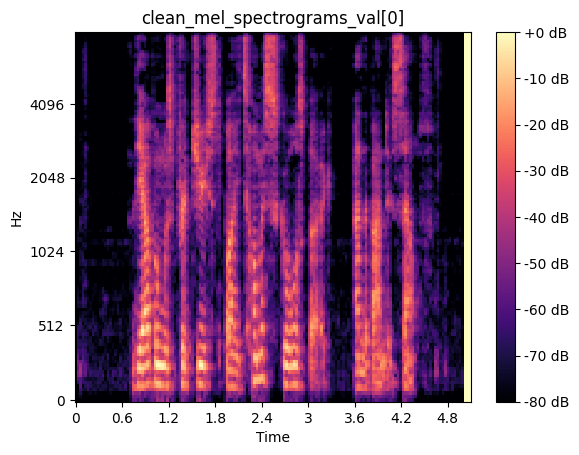

In [155]:
fig, ax = plt.subplots()
img = librosa.display.specshow(clean_mel_spectrograms_val[0][0], sr=sample_rate, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='clean_mel_spectrograms_val[0]')
plt.show()

# 將圖像保存至檔案
output_path = test_dir['visual'] + "clean_mel_spectrograms_val[0].png"  # 定義保存的檔案名稱和格式
fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
plt.close(fig)  # 避免顯示圖像 (若不需要可保留 plt.show())

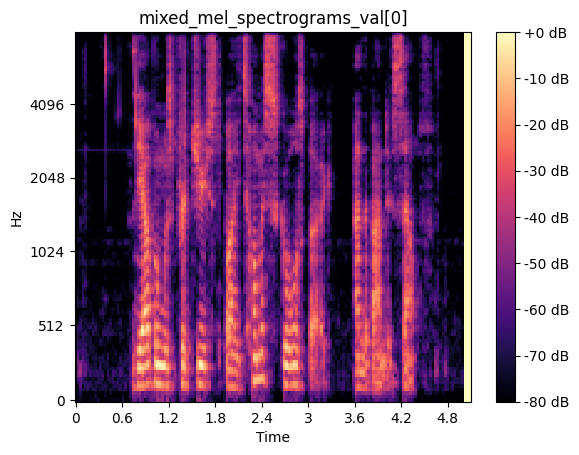

In [156]:
fig, ax = plt.subplots()
img = librosa.display.specshow(mixed_mel_spectrograms_val[0][0], sr=sample_rate, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='mixed_mel_spectrograms_val[0]')
plt.show()

# 將圖像保存至檔案
output_path = test_dir['visual'] + "mixed_mel_spectrogram_val[0].png"  # 定義保存的檔案名稱和格式
fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
plt.close(fig)  # 避免顯示圖像 (若不需要可保留 plt.show())

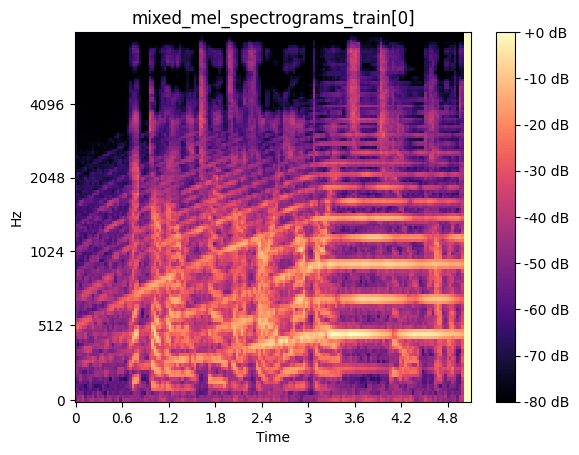

In [157]:
fig, ax = plt.subplots()
img = librosa.display.specshow(mixed_mel_spectrograms_train[0][0], sr=sample_rate, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='mixed_mel_spectrograms_train[0]')
plt.show()

# 將圖像保存至檔案
output_path = test_dir['visual'] + "mixed_mel_spectrograms_train[0].png"  # 定義保存的檔案名稱和格式
fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
plt.close(fig)  # 避免顯示圖像（若不需要可保留 plt.show()）

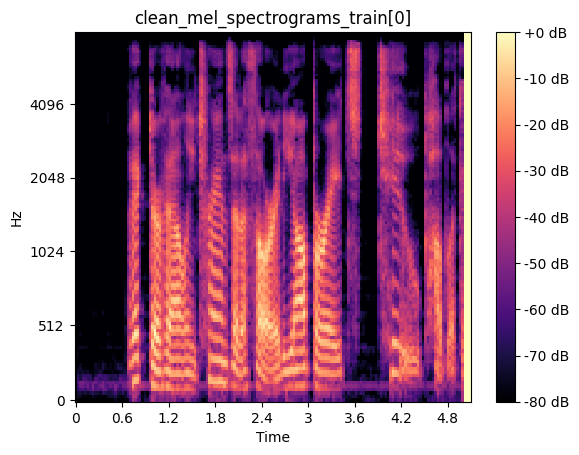

In [158]:
fig, ax = plt.subplots()
img = librosa.display.specshow(clean_mel_spectrograms_train[0][0], sr=sample_rate, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='clean_mel_spectrograms_train[0]')
plt.show()

# 將圖像保存至檔案
output_path = test_dir['visual'] + "clean_mel_spectrograms_train[0].png"  # 定義保存的檔案名稱和格式
fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
plt.close(fig)  # 避免顯示圖像（若不需要可保留 plt.show()）

### Training

In [159]:
class DenoiseAutoencoder(nn.Module):
    def __init__(self):
        super(DenoiseAutoencoder, self).__init__()
        # 編碼器
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # 全連接層 ### shape 有問題
        self.fc1 = nn.Linear(10240, 256)  # 假設輸入大小為 (1, 64, 64)
        self.fc2 = nn.Linear(256, 10240)

        # 解碼器
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(1),
        )

    def forward(self, x):
        # 編碼器
        x = self.encoder(x)
        
        # 將特徵展平
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        
        # 全連接層處理
        x = self.fc1(x)
        x = self.fc2(x)
        
        # 恢復形狀為解碼器輸入
        x = x.view(batch_size, 128, 8, 10)
        # 解碼器
        x = self.decoder(x)
        return x

In [160]:
# Model參數
num_epochs = 40
batch_size = 256
learning_rate = 0.5
lr_decay_step = 101
lr_decay_gamma = 0.8

In [161]:
class AudioDataset(Dataset):
    def __init__(self, mixed_data, clean_data):
        self.mixed = mixed_data
        self.clean = clean_data
    
    def __len__(self):
        return len(self.mixed)
    
    def __getitem__(self, idx):
        return self.mixed[idx], self.clean[idx]

dataset = AudioDataset(mixed_mel_spectrograms_train, clean_mel_spectrograms_train)
dataloader = DataLoader(dataset, batch_size=batch_size)
dataloader_val = DataLoader(AudioDataset(mixed_mel_spectrograms_val, clean_mel_spectrograms_val), batch_size=len(mixed_mel_spectrograms_val))


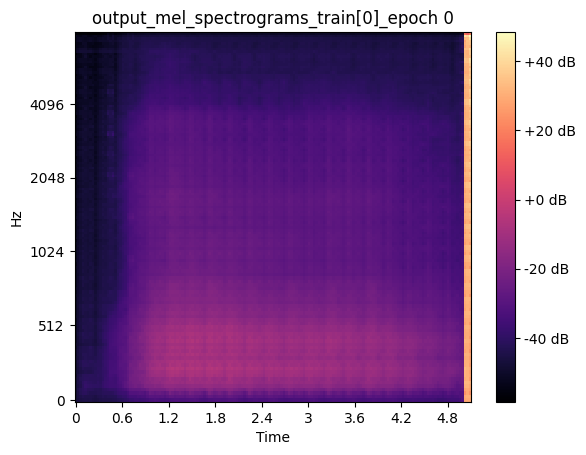

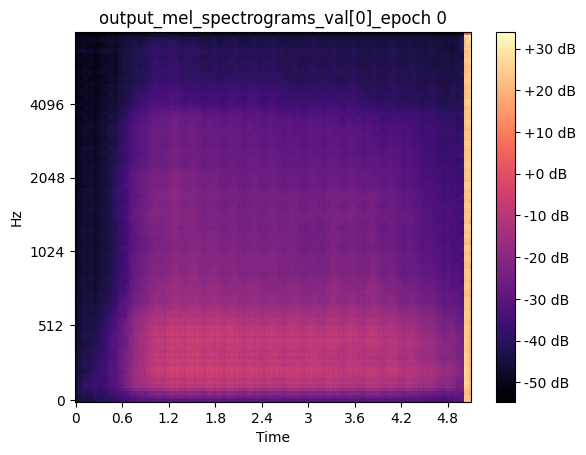

Epoch [1/40], Training Loss: 1037.821777343750, Validation Loss: 1146.965454101562, Learning Rate: 0.50000000
Epoch [2/40], Training Loss: 328.757019042969, Validation Loss: 369.449859619141, Learning Rate: 0.50000000
Epoch [3/40], Training Loss: 213.536727905273, Validation Loss: 218.287033081055, Learning Rate: 0.50000000
Epoch [4/40], Training Loss: 193.427398681641, Validation Loss: 172.883346557617, Learning Rate: 0.50000000
Epoch [5/40], Training Loss: 182.483474731445, Validation Loss: 160.108718872070, Learning Rate: 0.50000000
Epoch [6/40], Training Loss: 171.620468139648, Validation Loss: 146.606262207031, Learning Rate: 0.50000000
Epoch [7/40], Training Loss: 161.688186645508, Validation Loss: 138.347808837891, Learning Rate: 0.50000000
Epoch [8/40], Training Loss: 154.107177734375, Validation Loss: 129.896926879883, Learning Rate: 0.50000000
Epoch [9/40], Training Loss: 149.830520629883, Validation Loss: 128.865661621094, Learning Rate: 0.50000000
Epoch [10/40], Training Lo

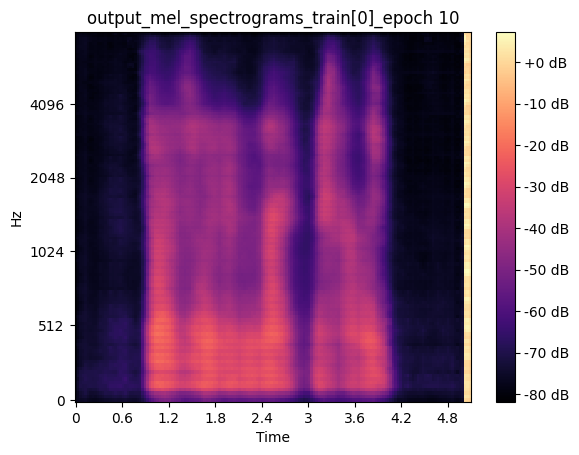

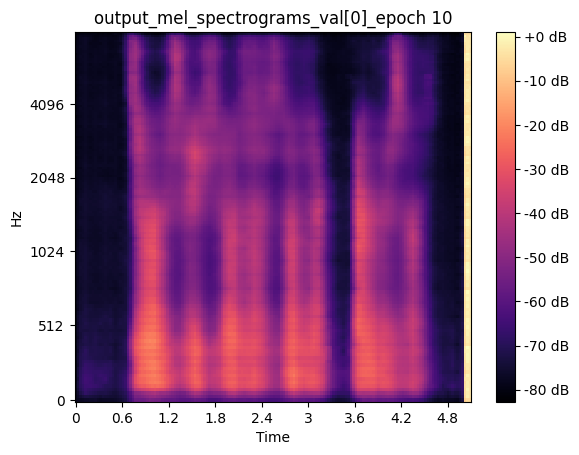

Epoch [11/40], Training Loss: 139.538589477539, Validation Loss: 121.379066467285, Learning Rate: 0.50000000
Epoch [12/40], Training Loss: 134.716537475586, Validation Loss: 113.667892456055, Learning Rate: 0.50000000
Epoch [13/40], Training Loss: 130.378143310547, Validation Loss: 109.736312866211, Learning Rate: 0.50000000
Epoch [14/40], Training Loss: 126.305541992188, Validation Loss: 107.161300659180, Learning Rate: 0.50000000
Epoch [15/40], Training Loss: 122.666709899902, Validation Loss: 98.593544006348, Learning Rate: 0.50000000
Epoch [16/40], Training Loss: 120.100723266602, Validation Loss: 98.057678222656, Learning Rate: 0.50000000
Epoch [17/40], Training Loss: 116.823562622070, Validation Loss: 97.762649536133, Learning Rate: 0.50000000
Epoch [18/40], Training Loss: 113.836090087891, Validation Loss: 93.818069458008, Learning Rate: 0.50000000
Epoch [19/40], Training Loss: 111.648620605469, Validation Loss: 93.624435424805, Learning Rate: 0.50000000
Epoch [20/40], Training 

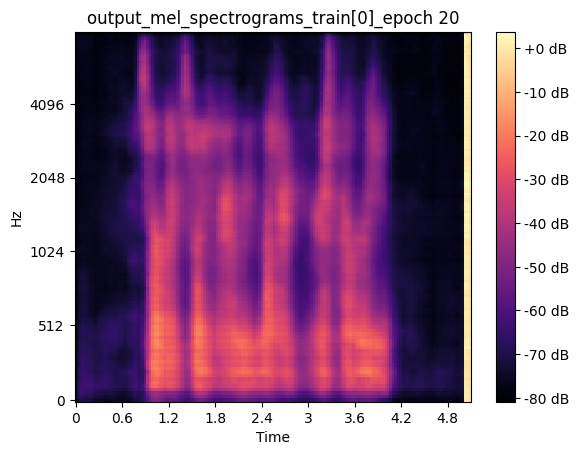

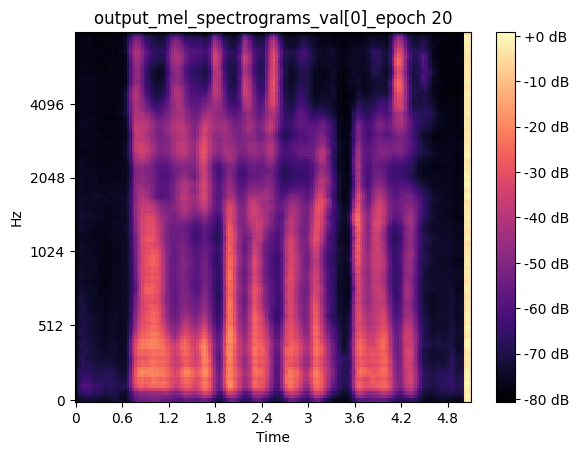

Epoch [21/40], Training Loss: 108.109634399414, Validation Loss: 95.351356506348, Learning Rate: 0.50000000
Epoch [22/40], Training Loss: 106.395973205566, Validation Loss: 94.563476562500, Learning Rate: 0.50000000
Epoch [23/40], Training Loss: 105.978950500488, Validation Loss: 93.722023010254, Learning Rate: 0.50000000
Epoch [24/40], Training Loss: 103.593063354492, Validation Loss: 96.809654235840, Learning Rate: 0.50000000
Epoch [25/40], Training Loss: 103.397102355957, Validation Loss: 93.543388366699, Learning Rate: 0.50000000
Epoch [26/40], Training Loss: 101.683975219727, Validation Loss: 96.814079284668, Learning Rate: 0.50000000
Epoch [27/40], Training Loss: 100.380577087402, Validation Loss: 97.450370788574, Learning Rate: 0.50000000
Epoch [28/40], Training Loss: 99.464912414551, Validation Loss: 100.445205688477, Learning Rate: 0.50000000
Epoch [29/40], Training Loss: 97.016502380371, Validation Loss: 100.280487060547, Learning Rate: 0.50000000
Epoch [30/40], Training Loss

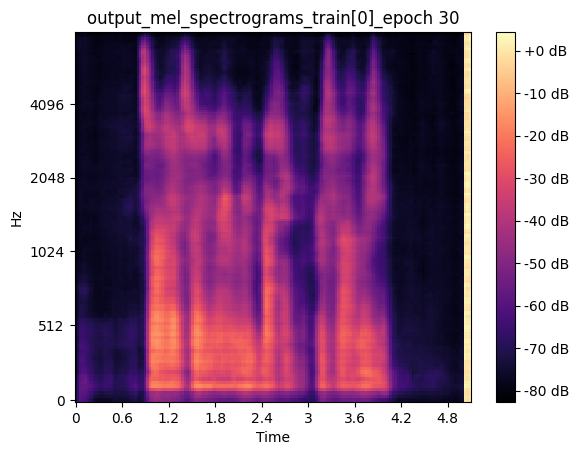

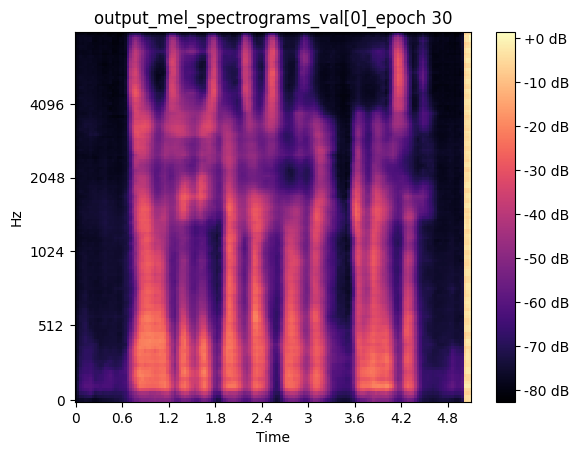

Epoch [31/40], Training Loss: 94.672256469727, Validation Loss: 94.057456970215, Learning Rate: 0.50000000
Epoch [32/40], Training Loss: 95.391372680664, Validation Loss: 91.374984741211, Learning Rate: 0.50000000
Epoch [33/40], Training Loss: 93.660743713379, Validation Loss: 89.410171508789, Learning Rate: 0.50000000
Epoch [34/40], Training Loss: 92.431686401367, Validation Loss: 88.313278198242, Learning Rate: 0.50000000
Epoch [35/40], Training Loss: 92.049468994141, Validation Loss: 90.345214843750, Learning Rate: 0.50000000
Epoch [36/40], Training Loss: 90.748870849609, Validation Loss: 86.971679687500, Learning Rate: 0.50000000
Epoch [37/40], Training Loss: 90.666397094727, Validation Loss: 85.812110900879, Learning Rate: 0.50000000
Epoch [38/40], Training Loss: 89.896598815918, Validation Loss: 84.227775573730, Learning Rate: 0.50000000
Epoch [39/40], Training Loss: 89.159790039062, Validation Loss: 84.370399475098, Learning Rate: 0.50000000
Epoch [40/40], Training Loss: 88.4735

In [162]:
from torch.optim.lr_scheduler import StepLR
import gc
model = DenoiseAutoencoder()

# torchsummary.summary(model,(1,64,44))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=lr_decay_step, gamma=lr_decay_gamma)
training_losses = []
validation_losses = []
training_snrs = []
validation_snrs = []
train_input = torch.tensor(np.array([mixed_mel_spectrograms_train[0]]), dtype=torch.float32)
train_clean = torch.tensor(np.array([clean_mel_spectrograms_train[0]]), dtype=torch.float32)
val_input = torch.tensor(np.array([mixed_mel_spectrograms_val[0]]), dtype=torch.float32)
val_clean = torch.tensor(np.array([clean_mel_spectrograms_val[0]]), dtype=torch.float32)

# 訓練過程
for epoch in range(num_epochs):
    model.train()
    sum_loss = 0
    for (mixed, clean) in dataloader:
        
        optimizer.zero_grad()

        # 前向傳播
        outputs = model(mixed)
        loss = criterion(outputs, clean)
        sum_loss += loss.item()
            
        # 反向傳播和優化
        loss.backward()
        optimizer.step()
        
    # Step the scheduler to decay the learning rate
    scheduler.step()
    
    # count training loss and SNR
    snr = calculate_snr(clean, outputs)
    training_losses.append(sum_loss / len(dataloader))
    training_snrs.append(snr)
    
    if epoch % 10 == 0:
        fig, ax = plt.subplots()
        img = librosa.display.specshow(outputs[0][0].detach().cpu().numpy(), sr=sample_rate, x_axis='time', y_axis='mel', ax=ax)
        fig.colorbar(img, ax=ax, format='%+2.0f dB')
        ax.set(title=f'output_mel_spectrograms_train[0]_epoch {epoch}')
        plt.show()

        # 將圖像保存至檔案
        output_path = test_dir['visual'] + f'output_mel_spectrograms_train[0]_epoch {epoch}'  # 定義保存的檔案名稱和格式
        fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
        plt.close(fig)  # 避免顯示圖像 (若不需要可保留 plt.show())
        gc.collect()
    
    # count validation loss and SNR
    val_output = model(val_input)
    val_loss = criterion(val_output, val_clean)
    val_snr = calculate_snr(val_clean, val_output)
    validation_losses.append(val_loss.item())
    validation_snrs.append(val_snr)
    
    if epoch % 10 == 0:
        fig, ax = plt.subplots()
        img = librosa.display.specshow(val_output[0][0].detach().cpu().numpy(), sr=sample_rate, x_axis='time', y_axis='mel', ax=ax)
        fig.colorbar(img, ax=ax, format='%+2.0f dB')
        ax.set(title=f'output_mel_spectrograms_val[0]_epoch {epoch}')
        plt.show()

        # 將圖像保存至檔案
        output_path = test_dir['visual'] + f'output_mel_spectrograms_val[0]_epoch {epoch}'  # 定義保存的檔案名稱和格式
        fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
        plt.close(fig)  # 避免顯示圖像 (若不需要可保留 plt.show())
        gc.collect()
    
    # Optionally, print the current learning rate and loss
    current_lr = scheduler.get_last_lr()[0]
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.12f}, Validation Loss: {val_loss.item():.12f}, Learning Rate: {current_lr:.8f}")

### Plot Loss

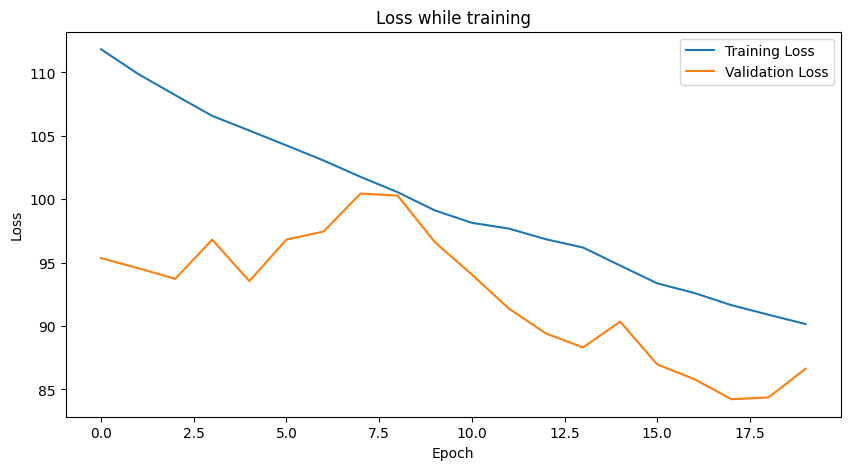

In [163]:
# plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(training_losses[20:], label="Training Loss")
plt.plot(validation_losses[20:], label="Validation Loss")
plt.title("Loss while training")
# plt.xlim([5, num_epochs])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 將圖像保存至檔案
output_path = test_dir['visual'] + "loss_while_training.png"  # 定義保存的檔案名稱和格式
fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
plt.close(fig)  # 避免顯示圖像（若不需要可保留 plt.show()）

### Plot SNR

Training SNR:   15.59086800 dB
Validation SNR: 17.60280800 dB


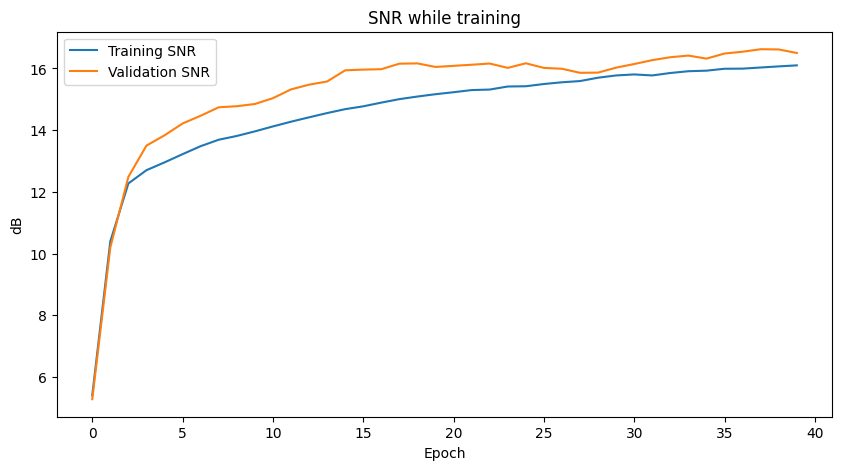

In [164]:
# print the SNR of the first training sample
model.eval()

with torch.no_grad():
    train_output = model(train_input)
    snr = calculate_snr(train_clean, train_output)
    print(f"Training SNR:   {snr:.8f} dB")

with torch.no_grad():
    val_output = model(val_input)
    snr = calculate_snr(val_clean, val_output)
    print(f"Validation SNR: {snr:.8f} dB")
    
# plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(training_snrs, label="Training SNR")
plt.plot(validation_snrs, label="Validation SNR")
plt.title("SNR while training")
plt.xlabel("Epoch")
plt.ylabel("dB")
plt.legend()
plt.show()

# 將圖像保存至檔案
output_path = test_dir['visual'] + "snr_while_training.png"  # 定義保存的檔案名稱和格式
fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
plt.close(fig)  # 避免顯示圖像（若不需要可保留 plt.show()）

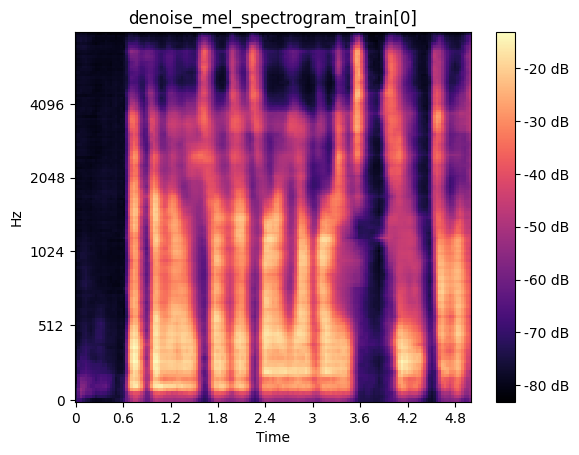

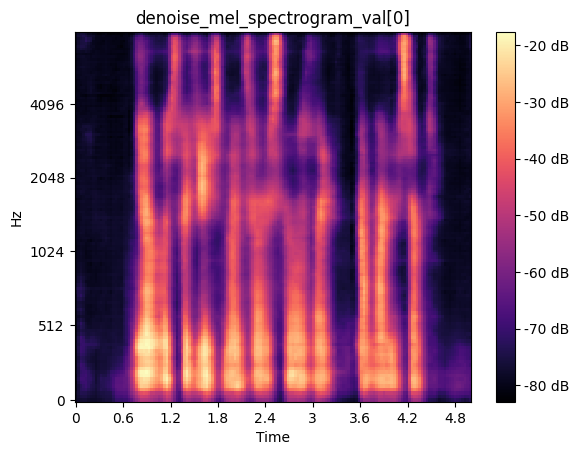

In [165]:
model.eval()

denoised_output = model(torch.from_numpy(mixed_mel_spectrograms_train[0]).unsqueeze(0))
denoised_output = denoised_output[:, :, :, :157]
fig, ax = plt.subplots()
img = librosa.display.specshow(denoised_output.squeeze(0).squeeze(0).detach().numpy(), sr=sample_rate, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='denoise_mel_spectrogram_train[0]')
plt.show()

# 將圖像保存至檔案
output_path = test_dir['visual'] + "denoise_mel_spectrogram_train[0].png"  # 定義保存的檔案名稱和格式
fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
plt.close(fig)  # 避免顯示圖像 (若不需要可保留 plt.show())

denoised_output = model(torch.from_numpy(mixed_mel_spectrograms_val[0]).unsqueeze(0))
denoised_output = denoised_output[:, :, :, :157]
fig, ax = plt.subplots()
img = librosa.display.specshow(denoised_output.squeeze(0).squeeze(0).detach().numpy(), sr=sample_rate, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='denoise_mel_spectrogram_val[0]')
plt.show()

# 將圖像保存至檔案
output_path = test_dir['visual'] + "denoise_mel_spectrogram_val[0].png"  # 定義保存的檔案名稱和格式
fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
plt.close(fig)  # 避免顯示圖像 (若不需要可保留 plt.show())

In [166]:
torch.save(model, "general_model.pth") # TODO

### Prediction

In [167]:
# # MelSpectrogram參數 (勿動)
# n_mels = 128                # 保持 Mel 頻譜圖的解析度
# n_fft = 1024                # 提高 FFT 窗口大小以適配更多信號頻率
# hop_length = 512            # 保持 hop_length 為 n_fft 的一半
# win_length = 1024           # 窗口大小與 n_fft 保持一致（或設為 None 使用默認值）
# sample_rate = 16000         # 採樣率保持不變，適合語音處理
# f_max = sample_rate // 2    # 預設為 Nyquist 頻率，即 8000 Hz
# duration = 5                # 音頻時長為 5 秒

In [168]:
# # MIXED
# mixed_waveform, sample_rate = librosa.load('test2.wav', sr=sample_rate)

# # if sr != sample_rate:
# #     mixed_waveform = librosa.resample(mixed_waveform, orig_sr=sr, target_sr=sample_rate)
    
# # cut to fit the duration
# if len(mixed_waveform) > sample_rate * duration:
#     mixed_waveform = mixed_waveform[:sample_rate * duration]

# mixed_mel_spectrogram = librosa.feature.melspectrogram(
#     y=mixed_waveform,
#     sr=sample_rate,
#     n_fft=n_fft,
#     hop_length=hop_length,
#     n_mels=n_mels
# )

# mixed_mel_spectrogram_db = librosa.power_to_db(
#     mixed_mel_spectrogram, 
#     ref=np.max, 
#     amin=1e-10  # 避免log(0)
# )

# # mixed_mel_tensor = torch.tensor(mixed_mel_spectrogram, dtype=torch.float32).squeeze().unsqueeze(0)
# mixed_mel_tensor = torch.tensor(mixed_mel_spectrogram_db, dtype=torch.float32).squeeze().unsqueeze(0)
# # mixed_mel_tensor = torch.tensor(np.load('nature_mixed.npy'), dtype=torch.float32).squeeze().unsqueeze(0)

# mixed_mel = mixed_mel_tensor
# mixed_output = mixed_mel.squeeze(0).squeeze(0).detach().numpy()
# mixed_output = librosa.db_to_power(mixed_output)

# audio_signal = librosa.feature.inverse.mel_to_audio(
#     mixed_output,
#     sr=sample_rate,
#     n_fft=n_fft,
#     hop_length=hop_length,
#     n_iter=512
# )

# audio_signal = audio_signal / np.max(np.abs(audio_signal))


# librosa.display.waveshow(audio_signal, sr=sample_rate)
# soundfile.write('test_librosa_mixed.wav', audio_signal, sample_rate)

In [169]:
# # DENOISED
# model.eval()  # 设置模型为评估模式
# # print(mixed_mel_tensor.shape)
# print(test_mixed_mel_spectrograms[0].shape)
# mixed_mel_np_array = np.array(test_mixed_mel_spectrograms)
# for i in range(len(mixed_mel_np_array)):
#     mixed_mel_np_array[i] = mixed_mel_np_array[i][:, :, :157]
# print(mixed_mel_np_array.shape)

# mixed_mel_tensor = torch.tensor(mixed_mel_np_array, dtype=torch.float32)

# denoised_output = model(mixed_mel_tensor)
# denoised_output = denoised_output[:, :, :, :157]
# print(denoised_output.shape)
# denoised_output = denoised_output.squeeze(0).squeeze(0).detach().numpy()
# denoised_output = librosa.db_to_power(denoised_output)

# audio_signal = librosa.feature.inverse.mel_to_audio(denoised_output, sr=sample_rate, n_iter=500)
# audio_signal = audio_signal / np.max(np.abs(audio_signal))

# librosa.display.waveshow(audio_signal, sr=sample_rate)
# soundfile.write('test_librosa_denoised.wav', audio_signal, sample_rate)
